# Active Subspace Example

---



In [1]:
## Test gradient
import numpy as np
import grama as gr
import pandas as pd
import seaborn as sns
import re
import itertools

from dfply import *
from grama.models import model_cantilever_beam

model = model_cantilever_beam()

Approximate the active subspace using Monte Carlo and central finite-differences.

In [2]:
## Approximate the active subspace
n = 500
seed = 101

df_directions = model >> \
    gr.ev_grad_fd(df_base=model >> gr.ev_monte_carlo(n_samples=n, seed=seed, skip=True)) >> \
    gr.tf_directions()
df_directions >> head

,H,V,E,Y,lam,output
0,0.706751,0.706748,0.000000,-0.031795,703.082947,g_stress
1,0.706368,-0.707443,0.000000,-0.023841,0.002953,g_stress
2,-0.039343,-0.005609,0.000000,-0.999210,0.000068,g_stress
3,0.000000,0.000000,1.000000,0.000000,0.000000,g_stress
4,0.448398,0.893834,-0.000044,0.000000,0.038094,g_displacement


We study the estimated eigenvalues to assess the dimensionality of each output.

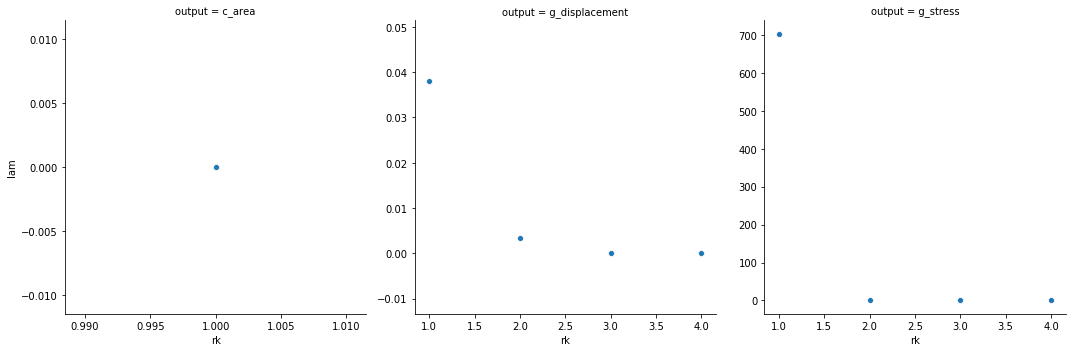

In [9]:
df_lam = \
    df_directions >> \
    group_by('output') >> \
    mutate(rk=dense_rank(-X.lam)) >> \
    ungroup()

## Visualize eigenvalues
sns.relplot(                                  
    data=df_lam,
    x="rk",
    y="lam",
    col="output",
    facet_kws=dict(sharex=False, sharey=False)
)

Based on these eigenvalues, we conclude:

- `c_area` is insensitive to the inputs considered
- `g_displacement` is one-dimensional in the inputs considered
- `g_stress` is one-dimensional in the inputs considered

Next we generate some function response samples to construct a *shadowplot*.

In [4]:
df_samples = model >> gr.ev_monte_carlo(n_samples=1e3, seed=seed)
df_samples >> head

,H,V,E,Y,c_area,g_stress,g_displacement
0,504.111685,1017.807404,2.623963e+07,38103.661554,9.0,4283.237354,0.115920
1,548.250670,1096.967949,2.826852e+07,42491.948545,9.0,5931.534769,0.111182
2,558.743398,912.187872,2.919771e+07,39240.858046,9.0,6553.496474,0.444275
3,409.182317,1079.125282,3.163639e+07,38537.764796,9.0,5464.262596,0.452015
4,361.849215,1026.254259,2.988417e+07,38811.896966,9.0,7965.153092,0.455316


Use the leading directions for the outputs to summarize the data and create a shadowplot.

/Users/zach/Git/py_grama/grama/transforms/summaries.py:152: UserWarning: ignoring df_weights columns {'output', 'lam'}
  warnings.warn("ignoring df_weights columns {}".format(diff), UserWarning)
/Users/zach/Git/py_grama/grama/transforms/summaries.py:152: UserWarning: ignoring df_weights columns {'output', 'lam'}
  warnings.warn("ignoring df_weights columns {}".format(diff), UserWarning)


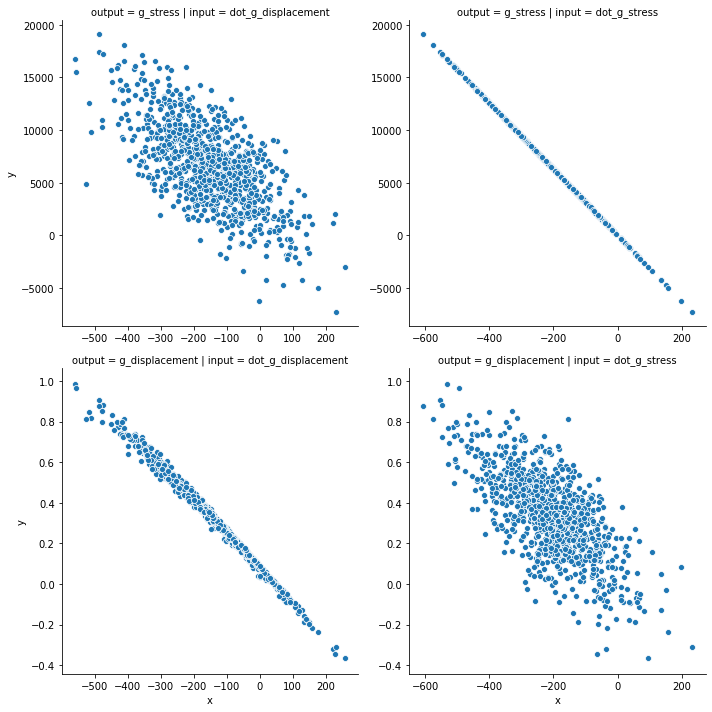

In [5]:
## Choose outputs to summarize
outputs = ["g_displacement", "g_stress"]

## Summarize the data
list_df = [df_samples]
for output in outputs:
    df_summary = df_samples >> \
        gr.tf_inner(df_weights=df_directions >> filter_by(X.output == output)) >> \
        select('dot0')
    df_summary = df_summary.rename(columns={"dot0": "dot_" + output})
    list_df.append(df_summary)
df_summary = \
    pd.concat(list_df, join='outer', ignore_index=False, axis=1) >> \
    select('g_stress', 'g_displacement', 'dot_g_displacement', 'dot_g_stress') >> \
    gather('output', 'y', ['g_stress', 'g_displacement']) >> \
    gather('input', 'x', ['dot_g_displacement', 'dot_g_stress'])
    
## Construct shadowplot
sns.relplot(                                  
    data=df_summary,
    x="x",
    y="y",
    col="input", 
    row="output",
    facet_kws=dict(sharex=False, sharey=False)
)

Observations:

- Both outputs tested are nearly one-dimensional along their respective active directions
- Both outputs have a weak dependence on the other's acti